In [12]:
%pip install davos
import davos

%conda install pytables

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [13]:
smuggle nltools as nlt            # pip: nltools==0.4.7

smuggle nilearn as nl             # pip: nilearn==0.10.0
smuggle nibabel as nib            # pip: nibabel==5.0.1

smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from skimage smuggle transform    # pip: scikit-image==0.20.0

from sklearn.decomposition smuggle IncrementalPCA as PCA  # pip: scikit-learn==1.2.1
from scipy.spatial.distance smuggle cdist                 # pip: scipy==1.10.1
from scipy.io smuggle loadmat
from tqdm smuggle tqdm            # pip: tqdm==4.64.1


smuggle requests                  # pip: requests==2.28.2

from datetime import datetime as dt
import os
import shutil
import pickle
import warnings

Download data

In [14]:
basedir = os.path.split(os.path.split(os.getcwd())[0])[0]
datadir = os.path.join(basedir, 'data')
nii_dir = os.path.join(datadir, 'nii')

zipfile_fname = os.path.join(nii_dir, 'Pieman2.zip')
check_file = os.path.join(nii_dir, 'download_complete.txt')
url = 'https://www.dropbox.com/s/7wiucuf4cprte6g/Pieman2.zip?dl=1'

if not os.path.exists(check_file):
    if not os.path.exists(nii_dir):
        os.makedirs(nii_dir)
    
    if not os.path.exists(zipfile_fname):
        with open(zipfile_fname, 'wb') as f:
            data = requests.get(url).content
            f.write(data)

        shutil.unpack_archive(zipfile_fname, nii_dir)
        os.remove(zipfile_fname)

        with open(check_file, 'w+') as f:
            f.write(str(dt.now()))

Load data

In [4]:
def resample_nii(x, target_res, precision=5):
    """
    Resample a Nifti image to have the given voxel dimensions
    Parameters
    ----------
    x : Nifti1Image
        Input Nifti image (a nibel Nifti1Image object)
    target_res : int or float or None
        Int or float (for cubic voxels) or a list or array of 3D voxel dimensions
    precision : int
        Number of decimal places in affine transformation matrix for resulting image (default: 5)
    Returns
    ----------
    results : Nifti1Image
         Re-scaled Nifti image
    """

    if type(x) is str:
        x = nib.load(x)

    if np.any(np.isnan(x.get_fdata())):
        img = x.get_fdata()
        img[np.isnan(img)] = 0.0
        x = nib.nifti1.Nifti1Image(img, x.affine)

    res = x.header.get_zooms()[0:3]
    scale = np.divide(res, target_res).ravel()

    target_affine = x.affine

    target_affine[0:3, 0:3] /= scale
    target_affine = np.round(target_affine, decimals=precision)

    # correct for 1-voxel shift
    target_affine[0:3, 3] -= np.squeeze(np.multiply(np.divide(target_res, 2.0), np.sign(target_affine[0:3, 3])))
    target_affine[0:3, 3] += np.squeeze(np.sign(target_affine[0:3, 3]))

    if len(scale) < np.ndim(x.get_fdata()):
        assert np.ndim(x.get_fdata()) == 4, 'Data must be 3D or 4D'
        scale = np.append(scale, 1)

    z = transform.resize(x.get_fdata(), scale, anti_aliasing=True, preserve_range=True)

    try:
        z[z < 1e-5] = np.nan
    except:
        pass
    return nib.Nifti1Image(z, target_affine)

In [15]:
from glob import glob as lsdir

In [16]:
nii_files = lsdir(os.path.join(nii_dir, 'Pieman2', '*', 'func', '*.nii.gz'))

In [39]:
data = {os.path.split(f)[-1][:-len('.nii.gz')]: nlt.data.Brain_Data(data=f) for f in nii_files}

with open(os.path.join(datadir, 'pieman2.pkl'), 'wb') as f:
    pickle.dump(data, f)

/Users/jmanning/opt/anaconda3/envs/pca-paper/lib/python3.9/site-packages/nilearn/image/resampling.py:612: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/Users/jmanning/opt/anaconda3/envs/pca-paper/lib/python3.9/site-packages/nilearn/image/resampling.py:612: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/Users/jmanning/opt/anaconda3/envs/pca-paper/lib/python3.9/site-packages/nilearn/image/resampling.py:612: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/Users/jmanning/opt/anaconda

In [40]:
data.keys()

dict_keys(['sub-010-task-word', 'sub-010-task-intact1', 'sub-017-task-intact1', 'sub-016-task-word', 'sub-016-task-intact1', 'sub-011-task-word', 'sub-011-task-intact1', 'sub-018-task-intact1', 'sub-002-task-intact1', 'sub-005-task-intact1', 'sub-004-task-word', 'sub-004-task-intact1', 'sub-003-task-word', 'sub-003-task-intact1', 'sub-014-task-word', 'sub-014-task-intact1', 'sub-013-task-word', 'sub-013-task-intact1', 'sub-012-task-intact1', 'sub-012-task-word', 'sub-015-task-intact1', 'sub-006-task-intact1', 'sub-001-task-word', 'sub-001-task-intact1', 'sub-008-task-intact1', 'sub-009-task-intact1', 'sub-007-task-intact1'])

In [42]:
def subj2cond(x):
    if 'intact' in x:
        return 'intact'
    elif 'paragraph' in x:
        return 'paragraph'
    elif 'word' in x:
        return 'word'
    elif 'rest' in x:
        return 'rest'
    else:
        raise Exception('Unknown condition')

In [47]:
x = {}
for k, v in data.items():
    if subj2cond(k) in x:
        x[subj2cond(k)].append(v)
    else:
        x[subj2cond(k)] = [v]

with open(os.path.join(datadir, 'pieman2_organized.pkl'), 'wb') as f:
    pickle.dump(x, f)

In [45]:
len(data)

27

In [19]:
x = nlt.data.Brain_Data(data=nii_files[0])

/Users/jmanning/opt/anaconda3/envs/pca-paper/lib/python3.9/site-packages/nilearn/image/resampling.py:612: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/Users/jmanning/opt/anaconda3/envs/pca-paper/lib/python3.9/site-packages/nilearn/image/resampling.py:612: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/Users/jmanning/opt/anaconda3/envs/pca-paper/lib/python3.9/site-packages/nilearn/image/resampling.py:612: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/Users/jmanning/opt/anaconda

In [29]:
x.data

array([[ 0.17282991, -0.12061401, -0.50474465, ..., -1.1449653 ,
        -1.3178625 ,  0.65759575],
       [ 0.19478686, -0.30074275, -0.82352495, ...,  0.20095976,
         0.19040976, -0.37937072],
       [-1.112735  , -1.397963  , -1.4803919 , ...,  0.6228414 ,
         0.8670401 , -0.6322576 ],
       ...,
       [-0.47676408, -0.44914737, -0.4750421 , ...,  2.2613683 ,
         0.9599736 , -3.5703156 ],
       [-0.75222266, -1.4117543 , -2.193597  , ...,  1.4509306 ,
        -0.26783136, -4.4262843 ],
       [ 1.7593718 ,  1.7909242 ,  1.0897304 , ..., -0.8917255 ,
        -2.897642  , -4.4200788 ]], dtype=float32)

In [7]:
x3 = resample_nii(nii_files[0], target_res=[6, 6, 6])

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/Users/jmanning/opt/anaconda3/envs/pca-paper/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/Users/jmanning/opt/anaconda3/envs/pca-paper/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

In [20]:
from nilearn.plotting import plot_epi

NameError: name 'x' is not defined

In [25]:
x = nib.load(nii_files[0])

In [48]:
from nibabel.processing import conform

In [ ]:
nib.Nifti1Image()

In [35]:
x2 = nib.Nifti1Image(x.get_fdata()[:, :, :, 0], x.affine, x.header)

In [54]:
x2.shape

(61, 73, 61)

In [55]:
x3 = conform(x2, out_shape=(30, 36, 30))

/Users/jmanning/opt/anaconda3/envs/pca-paper/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


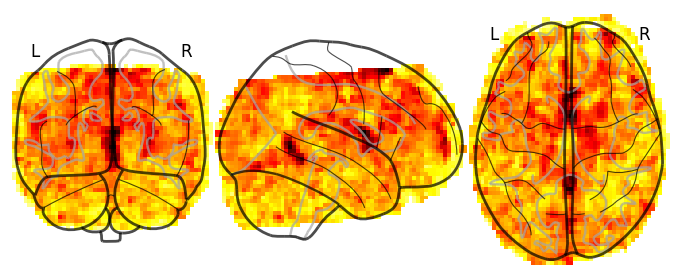

In [58]:
plot_glass_brain(x2)

In [61]:
np.array(x3.get_fdata()).ravel()

array([nan, nan, nan, ..., nan, nan, nan])

/Users/jmanning/opt/anaconda3/envs/pca-paper/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/Users/jmanning/opt/anaconda3/envs/pca-paper/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


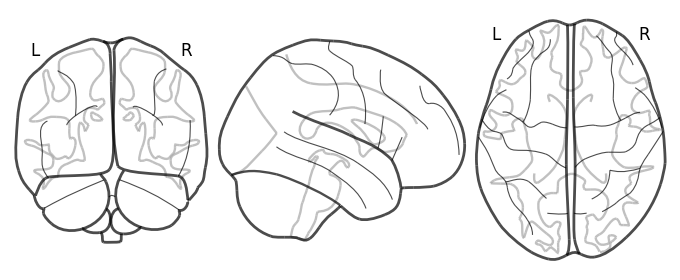

In [57]:
plot_glass_brain(x3)

In [27]:
x2 = resample_to_output(x, [2, 2, 2])

ValueError: This function can only deal with 3D images

In [13]:
nl.plotting.plot_glass_brain(x[0])

TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`

In [25]:
def nii2cmu(nifti_file, mask_file=None):
    def fullfact(dims):
        '''
        Replicates MATLAB's fullfact function (behaves the same way)
        '''
        vals = np.asmatrix(range(1, dims[0] + 1)).T
        if len(dims) == 1:
            return vals
        else:
            aftervals = np.asmatrix(fullfact(dims[1:]))
            inds = np.asmatrix(np.zeros((np.prod(dims), len(dims))))
            row = 0
            for i in range(aftervals.shape[0]):
                inds[row:(row + len(vals)), 0] = vals
                inds[row:(row + len(vals)), 1:] = np.tile(aftervals[i, :], (len(vals), 1))
                row += len(vals)
            return inds
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        img = nib.load(nifti_file)
        mask = NiftiMasker(mask_strategy='background')
        if mask_file is None:
            mask.fit(nifti_file)
        else:
            mask.fit(mask_file)
    
    hdr = img.header
    S = img.get_sform()
    vox_size = hdr.get_zooms()
    im_size = img.shape
    
    if len(img.shape) > 3:
        N = img.shape[3]
    else:
        N = 1
    
    Y = np.float64(mask.transform(nifti_file)).copy()
    vmask = np.nonzero(np.array(np.reshape(mask.mask_img_.dataobj, (1, np.prod(mask.mask_img_.shape)), order='C')))[1]
    vox_coords = fullfact(img.shape[0:3])[vmask, ::-1]-1
    
    R = np.array(np.dot(vox_coords, S[0:3, 0:3])) + S[:3, 3]
    
    return {'Y': Y, 'R': R}

In [47]:
mask = os.path.join(nii_dir, 'Pieman2', 'masks', 'avg152T1_gray_3mm.nii.gz')

In [35]:
x = nii2cmu(nii_files[0], mask_file=mask)

In [48]:
mx = nii2cmu(mask)

In [4]:
conditions = ['intact', 'paragraph', 'word', 'rest']

def load_data(fname):
    htfa = loadmat(fname, simplify_cells=True)['posterior']
    weights = [pd.DataFrame(htfa['subjects'][i]['image_weights']['mean']) for i in range(len(htfa['subjects']))]
    data = {}    
    for c in conditions:
        data[c] = [w for w, n in zip(weights, htfa['subjects_names']) if c in n]
    
    return data

data = load_data(fname)

Load (computing and saving as needed) the reduced versions of the data using $k \in \{3, 4, 5, ..., 700\}$ components

In [5]:
def group_pca(data, n_components=None):
    pca = PCA(n_components=n_components)

    x = dw.stack(data)
    y = pca.fit_transform(x)

    return dw.unstack(pd.DataFrame(index=x.index, data=y))    

In [6]:
scratch_dir = os.path.join(basedir, 'data', 'scratch')
if not os.path.exists(scratch_dir):
    os.makedirs(scratch_dir)

reduced_data = {}
max_components = data['intact'][0].shape[1]

for c in conditions:
    reduced_data[c] = {}
    for n in tqdm(range(3, max_components + 1)):
        fname = os.path.join(scratch_dir, f'pca_{c}_{n}.pkl')        

        if not os.path.exists(fname):
            reduced_data[c][n] = group_pca(data[c], n_components=n)

            with open(fname, 'wb') as f:
                pickle.dump(reduced_data[c][n], f)

        with open(fname, 'rb') as f:
            reduced_data[c][n] = pickle.load(f)


 21%|██        | 146/698 [48:39<3:03:59, 20.00s/it]  


KeyboardInterrupt: 

In [ ]:
def accuracy(train, test):
    train = np.mean(np.stack(train, axis=2), axis=2)
    test = np.mean(np.stack(test, axis=2), axis=2)
    dists = cdist(train, test, metric='correlation')
    
    labels = np.argmin(dists, axis=1)
    return np.mean([i == d for i, d in enumerate(labels)])

In [ ]:
def cross_validation(data, n_folds=100):
    results = pd.DataFrame(columns=['Fold', 'Number of components', 'Decoding accuracy'])

    n = len(data[3]) // 2
    for i in tqdm(range(n_folds)):
        order = np.random.permutation(len(data[3]))

        for c in range(3, max_components + 1):
            x = pd.DataFrame(columns=['Fold', 'Number of components', 'Decoding accuracy'])
            x.loc[0, 'Fold'] = i
            x.loc[0, 'Number of components'] = c

            train = [data[c][o] for o in order[:n]]
            test = [data[c][o] for o in order[n:]]
            x.loc[0, 'Decoding accuracy'] = (accuracy(train, test) + accuracy(test, train)) / 2

            results = pd.concat([results, x], ignore_index=True)

    return results

In [ ]:
decoding_results = {}
for c in conditions:
    decoding_results[c] = cross_validation(reduced_data[c])
    sns.lineplot(decoding_results[c], x='Number of components', y='Decoding accuracy', label=c.capitalize())